# Milestone Project 2: SkimLit

The purpose of this project is to build a NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

Resource: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb

## Confirm access to a GPU

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1660 Ti (UUID: GPU-7fba9be9-5762-f892-8d0f-63529aeb6747)


## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), lets download the dataset.

It can be downloaded from the authors GitHub

In [2]:
# !git clone https://github.com/Franck-Dernoncourt/pubmed-rct 
# !ls pubmed-rct

In [3]:
# Check what files are in PubMed_20K dataset
!dir pubmed-rct

 Volume in drive C is OS
 Volume Serial Number is C4D7-ECF5

 Directory of C:\Users\rajat\OneDrive\Desktop\Tensorflow\MP-2 SkimLit\pubmed-rct

11-03-2023  22:59    <DIR>          .
30-04-2023  17:20    <DIR>          ..
11-03-2023  22:59    <DIR>          PubMed_200k_RCT
18-03-2023  22:45    <DIR>          PubMed_200k_RCT_numbers_replaced_with_at_sign
11-03-2023  22:59    <DIR>          PubMed_20k_RCT
11-03-2023  22:59    <DIR>          PubMed_20k_RCT_numbers_replaced_with_at_sign
11-03-2023  22:59             2,403 README.md
               1 File(s)          2,403 bytes
               6 Dir(s)  116,166,176,768 bytes free


In [4]:
import os
os.listdir("pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign")

['dev.txt', 'test.txt', 'train.txt']

In [5]:
# Start our experiment using 20K dataset with numbers replaced by "@" sign
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# Check all the filenames in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess Data

Lets explore and understand the data.

One of the best way to do this is to visualize the data

So writing a function to read in all the lines of the target files

In [7]:
# Create function to read lines of a document
def get_lines(filename):
    """
    Reads file name (a text filename) and returns the lines of text as a list.
    
    Args:
        filename: a string containing the target filepath.
        
    Returns:
        A list of strings with one string per line from the target filename.
    """
    with open(filename, "r") as f:
        return f.readlines()

In [8]:
# Reading the training text file
train_lines = get_lines(data_dir + "train.txt") # read the lines within train.txt
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

Converting the above extracted data into a form which will be easy for us to input to the model to train.

```
`[{'line_number': 0,
   'target': 'Background',
   'text': 'Emotional eating is associated with overeating and the development of obesity .\n',
   'total_lines': 11}]
```   

The function below works as follows:

* First it checks whether the first line is Id or not (###243543 or a normal line) 
* If its a normal line, it adds that line to an empty string to which each line is added until a line which only new line is reached.
* Once a new line is reached (indicated end of one abstract) the string to which all the lines were added is converted into a list of lines.
    * We iterate over that list by enumerating and on each line we split the line into target and text (split at '\t')
    * We add target, text, current line number, total lines to an empty dictionary
    * This dictionary is appended to an empty list which returned

In [10]:
def text_to_dict(filename):
    """
    Returns a list of dictionaries of abstract line data
    
    Takes in filename, reads its content and sorts through each line,
    extracting things like the target label, text of the sentence, 
    how many senteces are in the current abstract and what sentence 
    number the target line is.
    """
    input_lines = get_lines(filename) # get all lines from file name
    abstract_lines = "" # create an empty abstract
    abstract_samples = [] # create an empty list of abstracts
    
    # Loop through each line in target file
    for line in input_lines:
        if line.startswith("###"):  # check to see if the line is an ID line
            abstract_id = line
            abstract_lines = "" # reset the abstract string if the line is an ID line
        
        elif line.isspace():   # check to see if line is a new line (\n)
            abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines
            
            # iterate through each line in a single abstract and count them at same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # create an empty dictionaru for each line
                target_text_split = abstract_line.split("\t") # split target label from text
                line_data["target"] = target_text_split[0] # get target label
                line_data["text"] = target_text_split[1].lower() # get target text and lower it
                line_data["line_number"] = abstract_line_number #  line number of the line in the abstract
                line_data["total_lines"] = len(abstract_line_split) - 1 # number of total lines in the abstract
                abstract_samples.append(line_data) # add line data to abstract samples list
                
        else:# if the above conditions aren't fulfilled, the line contains a labelled sentence
            abstract_lines += line
            
    # return the created dictionary
    return abstract_samples     

In [11]:
# get data from file and preprocess it
train_samples = text_to_dict(data_dir + "train.txt")
val_samples = text_to_dict(data_dir + "dev.txt")
test_samples = text_to_dict(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135


In [12]:
# check the first abstract of training data
train_samples[:15]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Turning our data into dataframe for futhure visualization

In [13]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

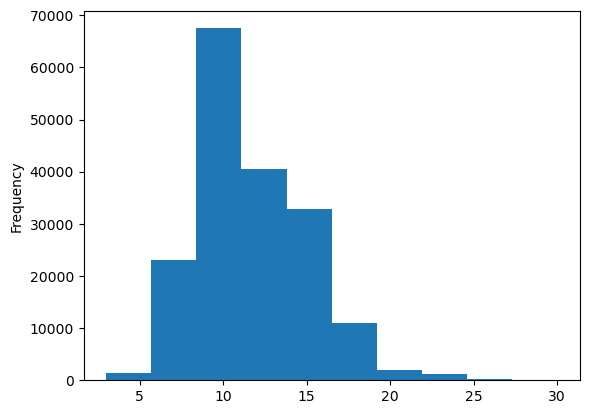

In [15]:
# Checking length of different lines
train_df.total_lines.plot.hist()

### Get the lists of Sentences

In [16]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
print(len(train_sentences), len(val_sentences), len(test_sentences))

180040 30212 30135


## Making numeric labels 

In [17]:
# one hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # sparse matrix are incompatibel with tensorflow tensor formations
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Checking the one hot encoded labels
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label Encode Labels

In [18]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_label_encoded = label_encoder.transform(test_df["target"].to_numpy())
                                             
# Checking the Training Labels
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# get class names and number of classes from Label Encoder Instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Strating a aseries of Modelling Experiments

Trying out a bunch of different models and seeing which one works the best.

Starting with a baseline model (Tf-idf Multinomial Naive Bayes Classifier)

## Model 0: Getting a Baseline

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("ti-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('ti-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluatig the baseline model on validation dataset
model_0.score(X = val_sentences,
              y = val_labels_encoded)

0.7218323844829869

In [22]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [23]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [24]:
# Calculate baseline results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 1: Conv1D Model

### Preparing our text for Deep Sequence Models

Creating vectorization and Embedding Layers

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [26]:
# Length of each sentence on average
sent_len = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_len)
avg_sent_len

26.338269273494777

(array([2.5486e+04, 7.1478e+04, 4.8888e+04, 2.0260e+04, 7.5560e+03,
        3.4370e+03, 1.4950e+03, 7.3700e+02, 3.2800e+02, 1.6500e+02,
        8.5000e+01, 4.9000e+01, 2.0000e+01, 1.5000e+01, 9.0000e+00,
        6.0000e+00, 8.0000e+00, 8.0000e+00, 3.0000e+00, 2.0000e+00,
        3.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1. ,  12.8,  24.6,  36.4,  48.2,  60. ,  71.8,  83.6,  95.4,
        107.2, 119. , 130.8, 142.6, 154.4, 166.2, 178. , 189.8, 201.6,
        213.4, 225.2, 237. , 248.8, 260.6, 272.4, 284.2, 296. ]),
 <BarContainer object of 25 artists>)

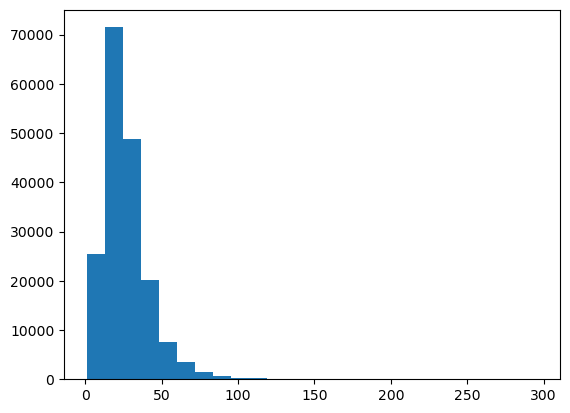

In [27]:
# Distribution 
import matplotlib.pyplot as plt
plt.hist(sent_len, bins=25)

In [28]:
# Length which covers 95% of sentence length
output_seq_len = int(np.percentile(sent_len, 95))
output_seq_len

55

In [29]:
# Maximum sequence length in training set
max(sent_len)

296

### Creating a Text Vectorizer

Creating a layer which maps out texts from words to numbers.

In [30]:
# Number of words in our vocabulary (taken from table 2 in https://arxiv.org/abs/1710.06071)
max_tokens = 68000

In [31]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens = max_tokens,  # number of words in vocabulary
                                    output_sequence_length = output_seq_len)  # derived output length of vectorized sequences

In [32]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [33]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
secondary outcomes included fasting and @-hour glucose and insulin , the area under the curves for insulin and insulin secretion , norepinephrine , insulin sensitivity , acute insulin response to glucose , and @-hour blood pressure .

Length of text: 37

Vectorized text: [[ 151   75  121  662    3  629  268    3  277    2  449  353    2 3161
    11  277    3  277 1967 4478  277  509  229  277  142    6  268    3
   629  107  200    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [34]:
# Number of words in our training vocabuulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [35]:
# Config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Creating a custom Text Embedding

In [36]:
# Creating an embedding layer
from tensorflow.keras.layers import Embedding
token_embed = Embedding(input_dim = len(rct_20k_text_vocab), # Length of our vocabulary
                        output_dim = 128, # Different embedding sizes results in drastically different numbers of parameters to train
                        mask_zero = True, # use masking to handle variable sequence lenghts (save space)
                        name = "token_embedding")

In [37]:
# Show example embedding
import random
target_sentence = random.choice(train_sentences)
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 cognitive behaviour therapy ( cbt ) is an effective treatment for depression .

Sentence after vectorization (before embedding):
 [[ 301 1250   66 1239   20   26  137   19   11  255    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[-0.01431565 -0.0289346  -0.00431182 ...  0.03039089  0.02898455
   -0.04477172]
  [ 0.04331901 -0.00260938  0.04953035 ... -0.02326776 -0.02854263
   -0.04458223]
  [ 0.0165456   0.02778833  0.04252536 ... -0.03309231 -0.04636994
    0.04267149]
  ...
  [ 0.03997084 -0.02283682  0.03445626 ...  0.02143702 -0.03591949
   -0.02420373]
  [ 0.03997084 -0.02283682  0.03445626 ...  0.02143702 -0.03591949
   -0.02420373]
  [ 0.03997084 -0.02283682  0.03445626 ...  0.02143702 -0.03591949
   -0.02420373]]]

Embedded sentence 

### Creating Datasets

Creating datasets using tensorflow dataApi to make sure our data loads as fast as possible

In [38]:

# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [39]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Creating Conv1D Model (with token embedding)

In [40]:
# Creating the model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # Vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compilet the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [41]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [42]:
# Number of batches in train dataset
len(train_dataset)

5627

In [43]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs = 3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
338/562 [=================>............] - ETA: 1s - loss: 1.0571 - accuracy: 0.5795

KeyboardInterrupt: 

In [44]:
# Evaluate on complete validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.6027 - accuracy: 0.7846


[0.6026740074157715, 0.7845889329910278]

In [45]:
# Getting prediction probabilities for each class
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.2417848e-01, 2.0247197e-01, 6.2995479e-02, 2.7737051e-01,
         3.2983642e-02],
        [4.2575628e-01, 3.1653962e-01, 1.2149398e-02, 2.3653473e-01,
         9.0199197e-03],
        [1.9353485e-01, 9.6981181e-03, 2.6699118e-03, 7.9404980e-01,
         4.7306927e-05],
        ...,
        [5.8761498e-06, 7.7125675e-04, 9.3220000e-04, 3.6038425e-06,
         9.9828702e-01],
        [5.0487250e-02, 4.9935448e-01, 7.3331110e-02, 5.8867160e-02,
         3.1796002e-01],
        [2.0332944e-01, 6.0933483e-01, 5.1777650e-02, 8.0277883e-02,
         5.5280183e-02]], dtype=float32),
 (30212, 5))

In [46]:
# Getting the predicted classes from probailites
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [47]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [48]:
# Calculatee model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.45889050708328,
 'precision': 0.781378994330078,
 'recall': 0.7845889050708328,
 'f1': 0.7819080306332177}

In [49]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature Extraction with Pretrained Token Embedding

Using pretrained word embeddings from Tensorflow Hub. More specifically the **Universal Sentence Encoder**

In [44]:
# Download pretrained Tensorflow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False,
                                        name = "universal_sentence_encoder")

In [48]:
# Download pretrained Tensorflow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_base/3",
                                        trainable = False)

In [47]:
import tensorflow as tf
tf.__version__

'2.10.1'

In [45]:
# test out pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random Sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence[0][:30]}")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random Sentence:
 these effects were strongest in vitamin a supplemented infants .


UnknownError: Exception encountered when calling layer "universal_sentence_encoder" "                 f"(type KerasLayer).

Graph execution error:

JIT compilation failed.
	 [[{{node EncoderDNN/EmbeddingLookup/EmbeddingLookupUnique/embedding_lookup/mod}}]] [Op:__inference_restored_function_body_18359]

Call arguments received by layer "universal_sentence_encoder" "                 f"(type KerasLayer):
  • inputs=["'these effects were strongest in vitamin a supplemented infants .'"]
  • training=None

### Building and Fitting a Feature extraction model 

In [52]:
# Creating a model
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="Model_2_USE_Feature_Extractor")

# Compile the model
model_2.compile(loss = "categorical_crossentropy",
            optimizer = "Adam",
            metrics = ["accuracy"])

In [53]:
# Summary of the model
model_2.summary()

Model: "Model_2_USE_Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [54]:
# Fit the model
history_model_2 = model_2.fit(train_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 15s 23ms/step - loss: 0.9171 - accuracy: 0.6519 - val_loss: 0.7944 - val_accuracy: 0.6888
Epoch 2/3
562/562 [==============================] - 14s 24ms/step - loss: 0.7659 - accuracy: 0.7041 - val_loss: 0.7522 - val_accuracy: 0.7055
Epoch 3/3
562/562 [==============================] - 12s 22ms/step - loss: 0.7480 - accuracy: 0.7130 - val_loss: 0.7358 - val_accuracy: 0.7111


In [55]:
# Evaluation on complete validation data
model_2.evaluate(valid_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.7368 - accuracy: 0.7145


[0.7368254065513611, 0.7144511938095093]

In [56]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.61559057e-01, 3.13453138e-01, 2.92783836e-03, 2.14002371e-01,
        8.05760454e-03],
       [3.07878405e-01, 5.24366498e-01, 5.69507433e-03, 1.58763662e-01,
        3.29633616e-03],
       [2.36299753e-01, 1.22968145e-01, 1.74100511e-02, 5.83066881e-01,
        4.02551033e-02],
       ...,
       [2.13637226e-03, 5.77055709e-03, 4.52472754e-02, 7.35755777e-04,
        9.46110010e-01],
       [3.85660911e-03, 5.29856756e-02, 1.86782792e-01, 1.51857582e-03,
        7.54856288e-01],
       [1.71927512e-01, 2.76226312e-01, 4.84855384e-01, 5.61980670e-03,
        6.13709204e-02]], dtype=float32)

In [57]:
# Prediction probabilities to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis = 1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2], dtype=int64)>

In [58]:
# Calculate results
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)

In [59]:
model_2_results

{'accuracy': 71.44512114391632,
 'precision': 0.7142990527897715,
 'recall': 0.7144512114391632,
 'f1': 0.7115223330644709}

## Model 3: Conv1D with Character Embeddigs

The paper I've ollowed used a combination of token and character-level embeddings.

### Creating a Character-level Tokenizer

In [23]:
# Creating a function to split senences into characters
def split_chars(text):
    return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

NameError: name 'random_train_sentence' is not defined

In [24]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [25]:
# average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([2.2108e+04, 7.0583e+04, 5.3952e+04, 2.2391e+04, 7.4540e+03,
        2.2350e+03, 8.0200e+02, 2.8700e+02, 1.1800e+02, 4.9000e+01,
        2.9000e+01, 1.3000e+01, 8.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 7.02500e+01, 1.39500e+02, 2.08750e+02, 2.78000e+02,
        3.47250e+02, 4.16500e+02, 4.85750e+02, 5.55000e+02, 6.24250e+02,
        6.93500e+02, 7.62750e+02, 8.32000e+02, 9.01250e+02, 9.70500e+02,
        1.03975e+03, 1.10900e+03, 1.17825e+03, 1.24750e+03, 1.31675e+03,
        1.38600e+03]),
 <BarContainer object of 20 artists>)

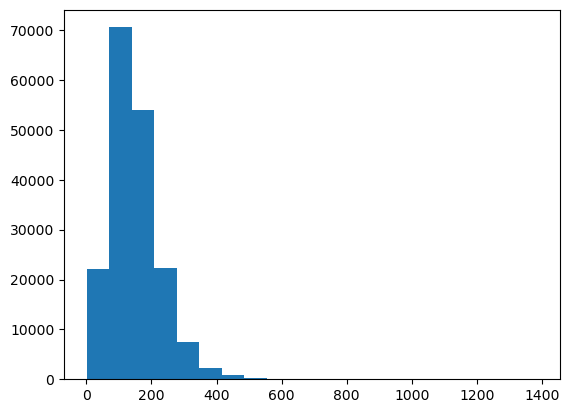

In [63]:
# Distribution of sequences at Character Level
plt.hist(char_lens, bins=20)

In [64]:
# Length that covers 95% of dataset
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [65]:
# Getting all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [66]:
# Create char-level token vectorizer instance 
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standrdize = None,
                                    name = "char_vectorizer")

In [67]:
# adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [68]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [69]:
# test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 t h e   h a z a r d   r a t i o   f o r   e x p o s u r e   t o   t d p   w a s   @   (   @   %   c i   ,   @ - @   @   ;   p   =   @   ,   l o g - r a n k   t e s t   )   .

Length of random_train_chars: 63

Vectorized chars:
 [[ 3 13  2 13  5 25  5  8 10  8  5  3  4  7 17  7  8  2 24 14  7  9 16  8
   2  3  7  3 10 14 20  5  9 11  4 14 12  7 18  8  5  6 23  3  2  9  3  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  

### Creating a Character-level Embedding

In [70]:
# Create char embedding layer
char_embed = Embedding(input_dim = len(char_vocab), # number of different characters
                       output_dim = 25, # this is the size of embedding in the Research paper
                       mask_zero = True, 
                       name = "char_embed")

In [71]:
# Test our character embedding layer
print(f"Charified Text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars:\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified Text:
 t h e   h a z a r d   r a t i o   f o r   e x p o s u r e   t o   t d p   w a s   @   (   @   %   c i   ,   @ - @   @   ;   p   =   @   ,   l o g - r a n k   t e s t   )   .

Embedded chars:
 [[[ 0.04082778 -0.01769382  0.02883108 ...  0.03401909  0.01244184
    0.00980778]
  [ 0.04997083  0.01378827 -0.04503852 ... -0.03412366 -0.03411859
    0.03615098]
  [ 0.04127941  0.011708    0.04072828 ... -0.03401755 -0.04240835
    0.04674239]
  ...
  [-0.00317917  0.01551975  0.02814331 ... -0.03690215 -0.01844762
   -0.00638769]
  [-0.00317917  0.01551975  0.02814331 ... -0.03690215 -0.01844762
   -0.00638769]
  [-0.00317917  0.01551975  0.02814331 ... -0.03690215 -0.01844762
   -0.00638769]]]

Character embedding shape: (1, 290, 25)


### Creating a Conv1D Model with Char-Level Embeddings

In [72]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [73]:
# Model sumary
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5

In [74]:
# Create Char-level Datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [75]:
# Fit the model on chars only
history_model_3 = model_3.fit(train_char_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1 * len(train_char_dataset)),
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 9ms/step - loss: 1.2651 - accuracy: 0.4792 - val_loss: 1.0540 - val_accuracy: 0.5788
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 1.0263 - accuracy: 0.5840 - val_loss: 0.9538 - val_accuracy: 0.6130
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.9375 - accuracy: 0.6288 - val_loss: 0.8745 - val_accuracy: 0.6576


In [76]:
# make predictions with char model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.18670066, 0.34620282, 0.07843044, 0.34682834, 0.04183776],
       [0.14593074, 0.61383337, 0.01169604, 0.1384083 , 0.09013155],
       [0.13125288, 0.16586027, 0.27468938, 0.338935  , 0.08926252],
       ...,
       [0.01101597, 0.03773162, 0.13850912, 0.05070568, 0.76203763],
       [0.03539824, 0.07674126, 0.4795301 , 0.06862597, 0.3397045 ],
       [0.4217185 , 0.3912054 , 0.11503355, 0.06312918, 0.00891339]],
      dtype=float32)

In [77]:
# Converting the probs to labels
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 3, ..., 4, 2, 0], dtype=int64)>

In [78]:
# Calculating results for model3
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 64.8715742089236,
 'precision': 0.6400868158352435,
 'recall': 0.6487157420892361,
 'f1': 0.6374323131389312}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

1. Create a token-level embedding (similar to `model_1`)
2. Create a character level model (similar to `model_3` with a slight modification)
3. Combine 1 and 2 with a Concatenate layer (`layers.Concatenate)
4. Build a series of output layers on top of 3 
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output.

In [79]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # BI-lstm LAYER
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Concatenate both token and char inpts (create hybrid token embedding)
token_char_concat = layers.Concatenate(name = "token_char_hybrid")([token_model.output,
                                                                    char_model.output])

# 4. Create output layers -- adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [80]:
# get a summary of our model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

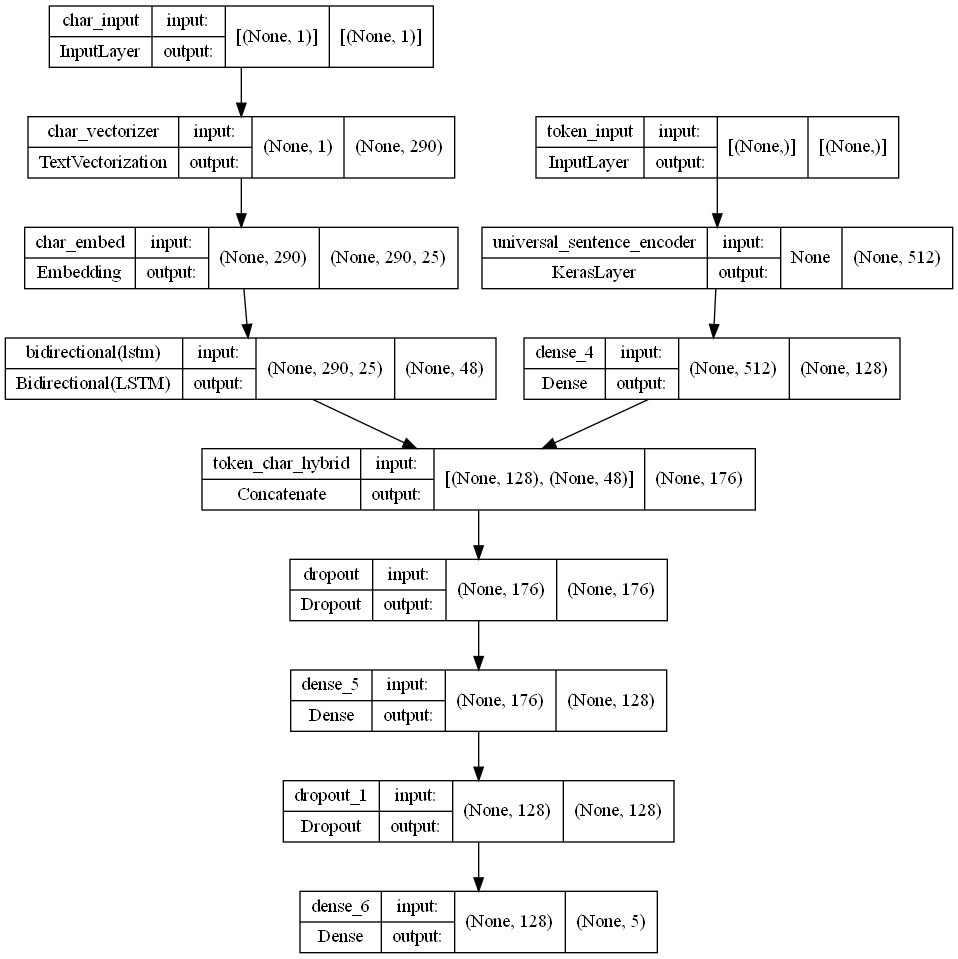

In [83]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True, show_layer_names=True, to_file='model.png')

In [84]:
# Compile the token char model
model_4.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

### Combining token and character data into a tf.data.Dataset

In [85]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [86]:
# Repeat above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

# prefetch and batch validaton data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [87]:
# Checkout our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting the Model

In [88]:
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch = int(0.1*len(train_char_token_dataset)),
                              epochs = 3,
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 73s 114ms/step - loss: 0.9834 - accuracy: 0.6075 - val_loss: 0.7804 - val_accuracy: 0.7008
Epoch 2/3
562/562 [==============================] - 63s 113ms/step - loss: 0.8040 - accuracy: 0.6895 - val_loss: 0.7175 - val_accuracy: 0.7264
Epoch 3/3
562/562 [==============================] - 57s 102ms/step - loss: 0.7733 - accuracy: 0.7047 - val_loss: 0.6926 - val_accuracy: 0.7344


In [89]:
# Evaluating the model
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 46s 49ms/step - loss: 0.6935 - accuracy: 0.7336


[0.6934548020362854, 0.7336157560348511]

In [90]:
# Make predictions using token-character hybrid model
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.5382008e-01, 3.4082988e-01, 5.1729265e-03, 1.9260105e-01,
        7.5761238e-03],
       [3.0635980e-01, 5.6146145e-01, 2.7994723e-03, 1.2779135e-01,
        1.5879107e-03],
       [3.1831357e-01, 1.5010549e-01, 3.0875035e-02, 4.7991297e-01,
        2.0792877e-02],
       ...,
       [5.6166726e-04, 5.4638954e-03, 5.4829862e-02, 1.5643063e-04,
        9.3898809e-01],
       [7.0587089e-03, 5.0333634e-02, 2.5850984e-01, 2.3241229e-03,
        6.8177366e-01],
       [1.8237470e-01, 3.4344685e-01, 3.3648011e-01, 3.3153091e-02,
        1.0454525e-01]], dtype=float32)

In [92]:
# Getting classes from pred probs
model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1], dtype=int64)>

In [94]:
# calculate results
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.36157818085529,
 'precision': 0.735094617050102,
 'recall': 0.7336157818085529,
 'f1': 0.7298718307017992}

## Model 5: Transfer Learning with Pretrained Token Embeddings + character Embeddings + Positional Embeddings`

In [95]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> **Note:** Any engineered features used to train a model need to be available at test time. In our case line numbers and total lines are available.

### Create Positional Embeddings

In [96]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<AxesSubplot:ylabel='Frequency'>

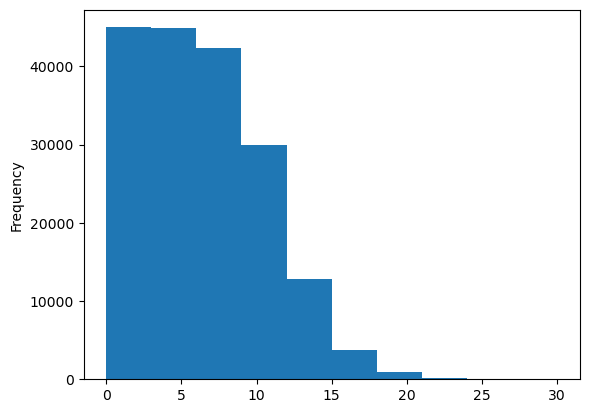

In [97]:
# Check the distribution of line number
train_df.line_number.plot.hist()

In [20]:
# use tensorflow to crate one-hot-encoded tensors of line numbers
train_line_num_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_num_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_num_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_num_one_hot[:10], train_line_num_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

_______________________________________________________________________________

Encoding and creating tensor for total_lines features


In [100]:
# Checking different Total lines
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<AxesSubplot:ylabel='Frequency'>

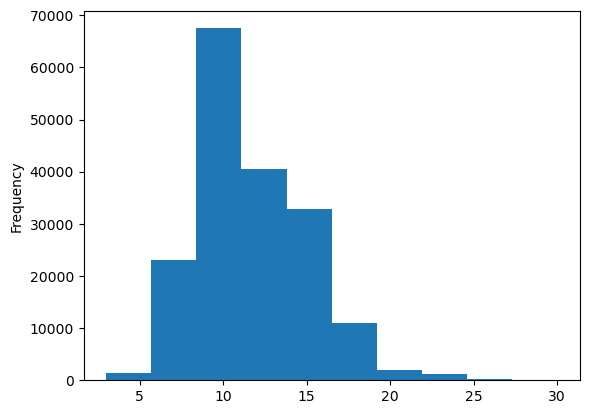

In [101]:
# Checking the distribution
train_df.total_lines.plot.hist()

In [103]:
# Check the coverage of "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [21]:
# Use Tensorflow to create one-hot encoded tensors
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a Tribrid Embedding Model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 and 1 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4 and 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3 and 4 and outputs into a tf.keras.Model

In [136]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [137]:
# Getting the model summary
model_5.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

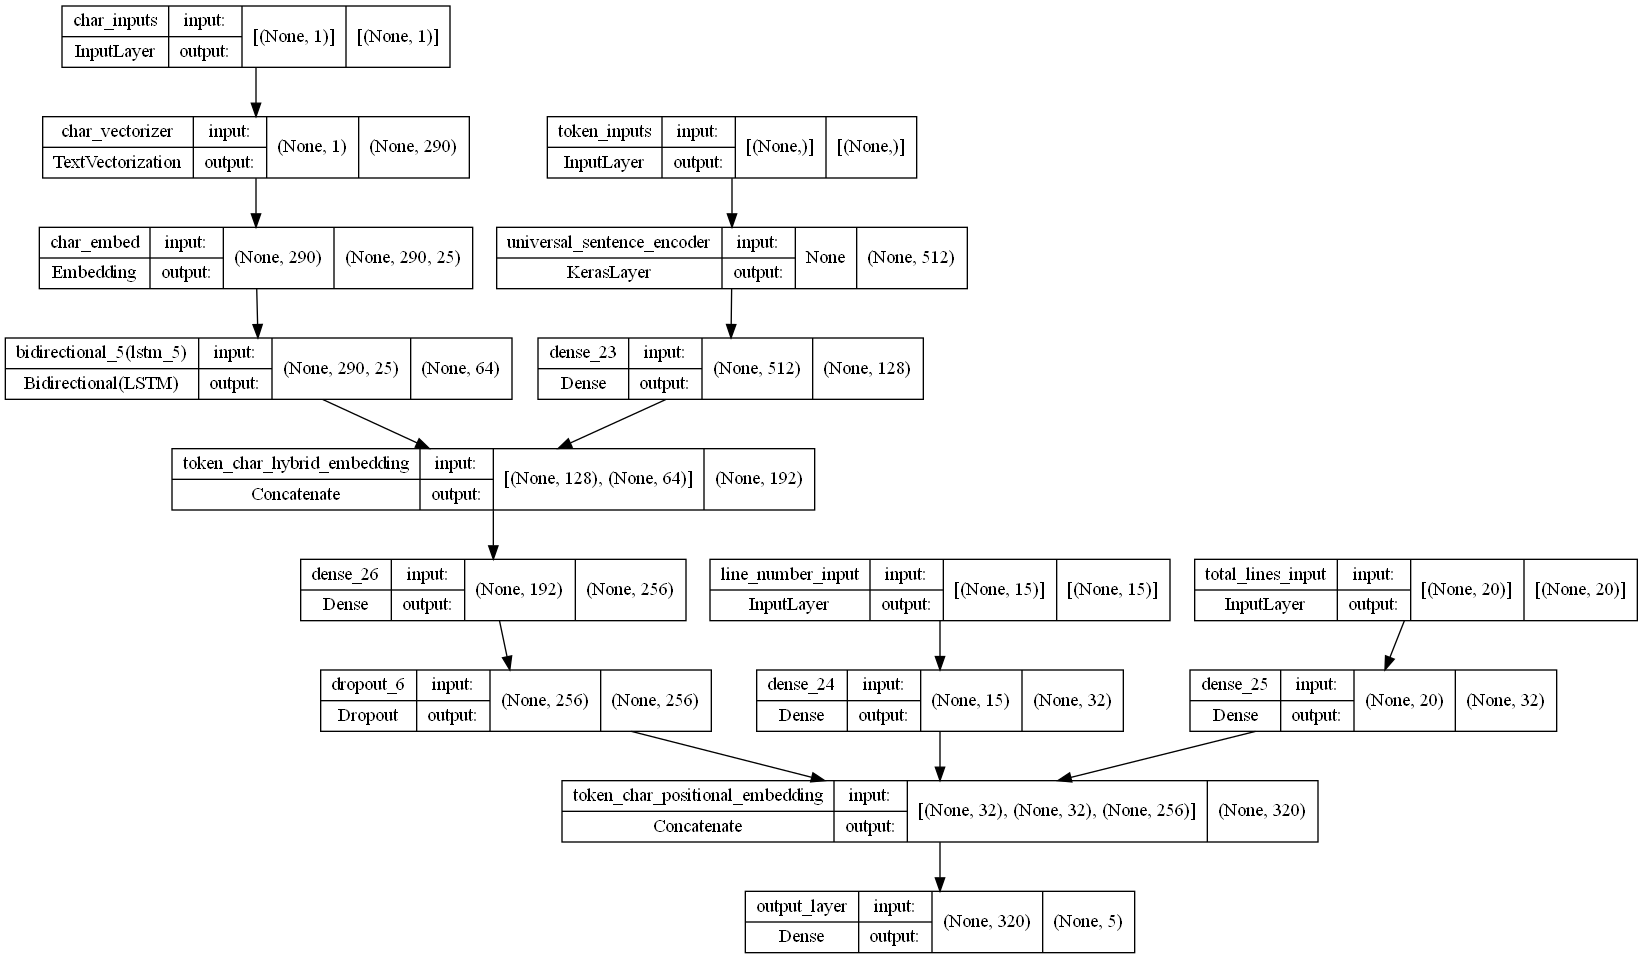

In [138]:
# Plotting the model
plot_model(model_5, show_shapes=True)

>**Label Fitting:** 
>
>Consider an example where our model gets too confifient on a single class, it may get stuck on that class and not consider other classes.
>
>Really Confident: [0.0, 0.0, 1.0, 0.0, 0.0]
>
>
>Label smoothing assigns some of the value from the highest prediction probability to other classes, in turn, hopefully, improvig generalization.
>
>After Label Smoothing: [0.01, 0.01, 0.96, 0.01, 0.01]

In [139]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Dataset Creation for faster Data Loading

In [26]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_num_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_num_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [141]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 108s 192ms/step - loss: 1.0888 - accuracy: 0.7294 - val_loss: 0.9768 - val_accuracy: 0.8092
Epoch 2/3
562/562 [==============================] - 112s 199ms/step - loss: 0.9644 - accuracy: 0.8182 - val_loss: 0.9464 - val_accuracy: 0.8314
Epoch 3/3
562/562 [==============================] - 104s 184ms/step - loss: 0.9479 - accuracy: 0.8235 - val_loss: 0.9371 - val_accuracy: 0.8298


In [142]:
# Evaluating model 5 
model_5.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 93s 98ms/step - loss: 0.9353 - accuracy: 0.8335


[0.9353024959564209, 0.8335098624229431]

In [143]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=0)
model_5_pred_probs

array([[0.51905775, 0.10548376, 0.00990531, 0.35010362, 0.01544949],
       [0.57111704, 0.07509743, 0.05106207, 0.2902838 , 0.01243966],
       [0.3028463 , 0.11672667, 0.14325015, 0.36722428, 0.06995256],
       ...,
       [0.03578055, 0.09616608, 0.03295238, 0.02856923, 0.8065318 ],
       [0.02969534, 0.27668542, 0.08625043, 0.02787907, 0.57948977],
       [0.19881342, 0.61327255, 0.08641616, 0.0366131 , 0.06488475]],
      dtype=float32)

In [144]:
# Getting the predicted Classes 
model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1], dtype=int64)>

In [145]:
# Calculate Results
model_5_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_5_preds)

In [146]:
model_5_results

{'accuracy': 83.35098636303455,
 'precision': 0.8325620737901287,
 'recall': 0.8335098636303455,
 'f1': 0.8324920919067552}

## Compare Model Results

In [147]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.458891,0.781379,0.784589,0.781908
model_2_pretrained_token_embedding,71.445121,0.714299,0.714451,0.711522
model_3_custom_char_embedding,64.871574,0.640087,0.648716,0.637432
model_4_hybrid_char_token_embedding,73.361578,0.735095,0.733616,0.729872
model_5_pos_char_token_embedding,83.350986,0.832562,0.833510,0.832492


In [148]:
# reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

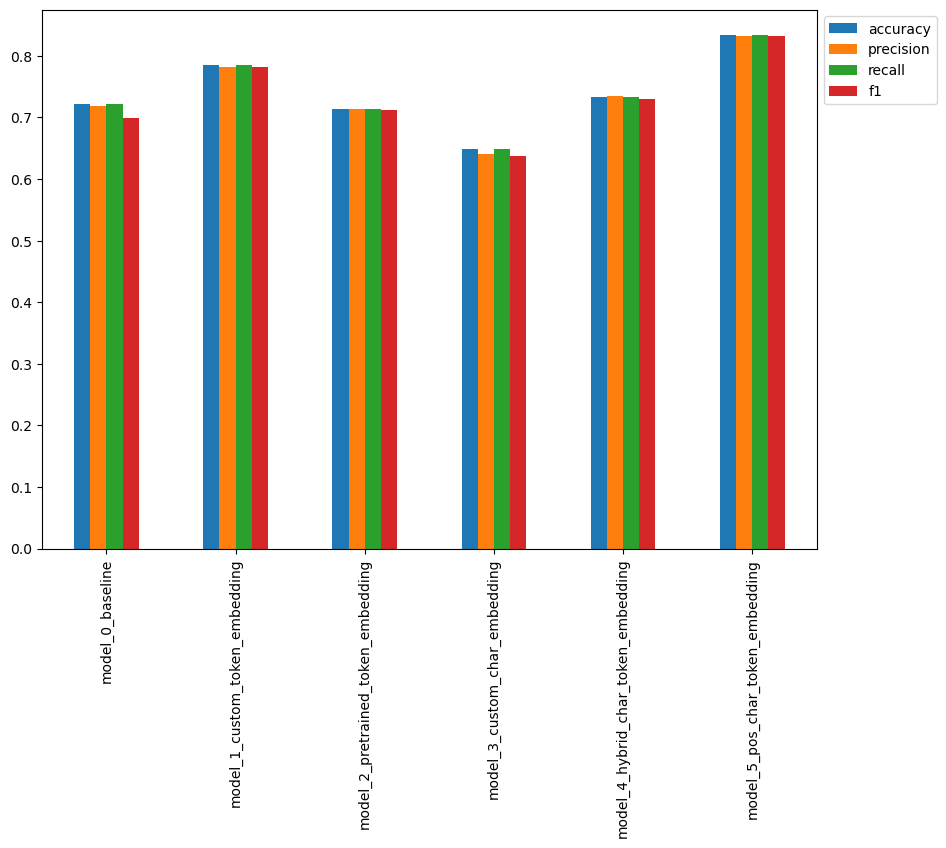

In [149]:
# plot and compare all metrics and models
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0,1.0))

<AxesSubplot:>

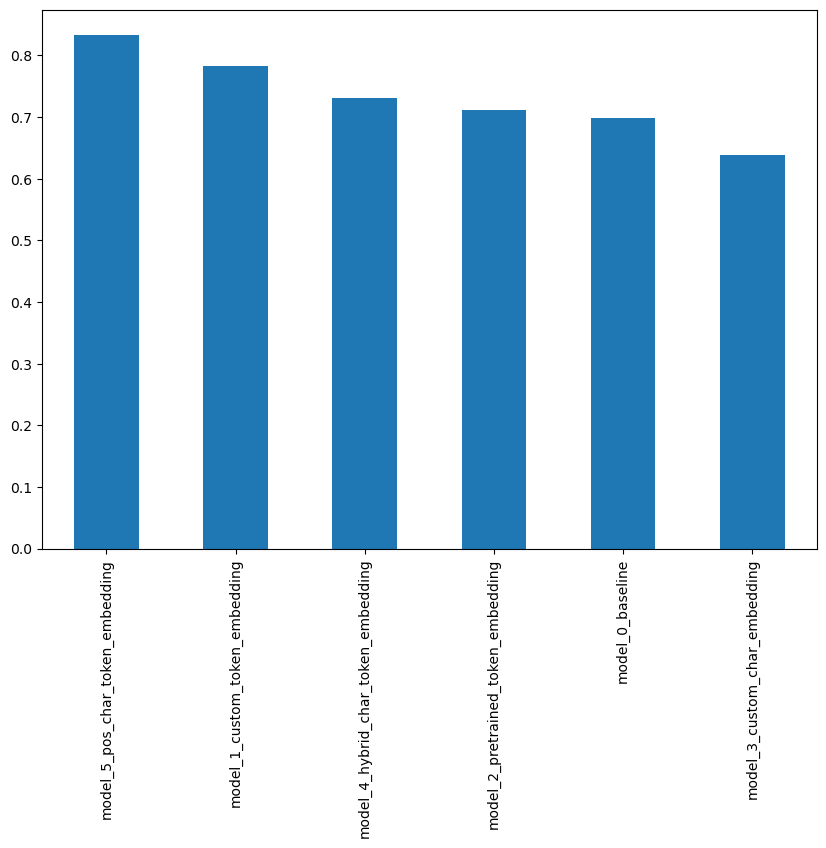

In [151]:
# Getting only F1 Scores
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7))

## Save and Load Model

In [152]:
# Saving the Best Performing Model
model_5.save("Skimlit_tribrid_20K")

INFO:tensorflow:Assets written to: Skimlit_tribrid_20K\assets


INFO:tensorflow:Assets written to: Skimlit_tribrid_20K\assets


In [15]:
# Loading our pretrained and saved model
import tensorflow as tf
loaded_model = tf.keras.models.load_model("Skimlit_tribrid_20K")

In [28]:
# Making predictions with Loaded model
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1], dtype=int64)>

In [29]:
# Getting loaded model results
loaded_model_results = calculate_results(y_true = val_labels_encoded,
                                         y_pred = loaded_preds)
loaded_model_results

{'accuracy': 83.35098636303455,
 'precision': 0.8325620737901287,
 'recall': 0.8335098636303455,
 'f1': 0.8324920919067552}

In [30]:
# Comparing with Model5 results
model_5_results

NameError: name 'model_5_results' is not defined

In [158]:
model_5_results == loaded_model_results

True

In [16]:
loaded_model.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

## Evaluate on the Test Dataset

In [33]:
# Create test datset
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_num_one_hot, # line numbers
                                                                test_total_lines_one_hot, # total lines
                                                                test_sentences, # train tokens
                                                                test_chars)) # train chars
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot) # train labels
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels)) # combine data and labels
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check shapes
test_pos_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [34]:
# Make Predections on the test dataswt
test_pred_prob = loaded_model.predict(test_pos_char_token_dataset,
                                      verbose = 1)

942/942 [==============================] - 40s 42ms/step


NameError: name 'test_pred_probs' is not defined

In [35]:
# Classes from probabilities
test_preds = tf.argmax(test_pred_prob, axis = 1)
test_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 1, 0], dtype=int64)>

In [37]:
# Evaluating model performance on the test set\
loaded_model_test_results = calculate_results(y_true = test_label_encoded,
                                              y_pred = test_preds)
loaded_model_test_results

{'accuracy': 82.95669487307119,
 'precision': 0.828251261139226,
 'recall': 0.8295669487307118,
 'f1': 0.8284923939024521}

## Find most wrong Predictions

In [38]:
# Get list class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

['OBJECTIVE',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'R

In [42]:
# Creating results dataframe
test_df["prediction"] = test_pred_classes # Prediction column containing predicted classes
test_df["pred_prob"] = tf.reduce_max(test_pred_prob, axis=1).numpy() # get the max probability of that class
test_df["correct"] = test_df["prediction"] == test_df["target"] # Binary column indicating if prediction is correct or false
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.455061,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,BACKGROUND,0.364887,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.765282,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.664401,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.773683,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.891441,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.450004,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.542094,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.475572,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.586694,True


In [47]:
# Find top 100 most wrong samples
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending = False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.952889,False
1827,CONCLUSIONS,nct@ ( clinicaltrials.gov ) .,18,18,BACKGROUND,0.939415,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.935281,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.932132,False
16633,CONCLUSIONS,clinicaltrials.gov identifier : nct@ .,19,19,BACKGROUND,0.931972,False
...,...,...,...,...,...,...,...
29835,CONCLUSIONS,"by age @ years , subjects remained small and t...",10,13,RESULTS,0.840378,False
13860,BACKGROUND,to evaluate efficacy and side effects of glyci...,0,9,OBJECTIVE,0.840063,False
29005,RESULTS,"we designed a patient-level , randomized , con...",3,14,METHODS,0.839323,False
23305,CONCLUSIONS,the c/s rate was higher in groups c and d ; ho...,10,11,RESULTS,0.838440,False


In [49]:
# Checking out the most wrong predictions
for row in top_100_wrong[0:10].itertuples():
    _, target, text, line_num, total_lines, prediction, pred_prob, _ = row
    print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line Number: {line_num}, Total Lines: {total_lines}\n")
    print(f"Text:\n{text}\n")
    print("---------------------------------\n")

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9528893232345581, Line Number: 4, Total Lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

---------------------------------

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9394151568412781, Line Number: 18, Total Lines: 18

Text:
nct@ ( clinicaltrials.gov ) .

---------------------------------

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9352811574935913, Line Number: 0, Total Lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

---------------------------------

Target: RESULTS, Pred: METHODS, Prob: 0.9321324825286865, Line Number: 4, Total Lines: 13

Text:
the primary endpoint is the cumulative three-year hiv incidence .

---------------------------------

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9319722652435303, Line Number: 19, Total Lines: 19

Text:
clinicaltrials.gov identifier : nct@ .

-------------------------------

## Make Example Predictions

In [1]:
# Getting the sample abstracts
import json
with open("skimlit_example_abstracts.json", "r") as f:
    example_abstract = json.load(f)
    
example_abstract

[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [2]:
import pandas as pd
abstracts = pd.DataFrame(example_abstract)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


### Using spaCy to create Sentencizer

In [3]:
# Create sentencizer
!pip install spaCy
from spacy.lang.en import English
nlp = English()  # Setup English sentence parser
sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser
doc = nlp(example_abstracts[0]["abstract"]) # create "doc" of parsed sequences
abstract_lines = [str(sent) for sent in list(doc.sents)]  # return detected sentences from doc in string
abstract_lines

     -------------------------------------- 12.2/12.2 MB 710.3 kB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 684.2 kB/s eta 0:00:00
     ------------------------------------ 181.6/181.6 kB 644.4 kB/s eta 0:00:00
     -------------------------------------- 96.8/96.8 kB 554.7 kB/s eta 0:00:00
     -------------------------------------- 48.9/48.9 kB 821.7 kB/s eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 656.6 kB/s eta 0:00:00
     ------------------------------------ 482.8/482.8 kB 756.2 kB/s eta 0:00:00
     ---------------------------------------- 7.0/7.0 MB 678.4 kB/s eta 0:00:00


ValueError: [E966] `nlp.add_pipe` now takes the string name of the registered component factory, not a callable component. Expected string, but got <spacy.pipeline.sentencizer.Sentencizer object at 0x000002023FE530C0> (name: 'None').

- If you created your component with `nlp.create_pipe('name')`: remove nlp.create_pipe and call `nlp.add_pipe('name')` instead.

- If you passed in a component like `TextCategorizer()`: call `nlp.add_pipe` with the string name instead, e.g. `nlp.add_pipe('textcat')`.

- If you're using a custom component: Add the decorator `@Language.component` (for function components) or `@Language.factory` (for class components / factories) to your custom component and assign it a name, e.g. `@Language.component('your_name')`. You can then run `nlp.add_pipe('your_name')` to add it to the pipeline.

In [9]:
doc = nlp(example_abstract[0]["abstract"])

In [11]:
for sent in doc.sents:
    print(sent)

ValueError: [E030] Sentence boundaries unset. You can add the 'sentencizer' component to the pipeline with: `nlp.add_pipe('sentencizer')`. Alternatively, add the dependency parser or sentence recognizer, or set sentence boundaries by setting `doc[i].is_sent_start`.

In [3]:
abstract_lines = example_abstract[0]["abstract"].split(".")
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs',
 ' Participants were randomly assigned to treatment or wait-list conditions',
 ' Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language',
 ' A response-cost program was applied to reduce problem behaviors and foster skills acquisition',
 ' Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures)',
 ' Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents',
 ' High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity',
 ' Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group',
 '']

In [4]:
len(abstract_lines)

9

In [5]:
del abstract_lines[8]

In [6]:
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs',
 ' Participants were randomly assigned to treatment or wait-list conditions',
 ' Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language',
 ' A response-cost program was applied to reduce problem behaviors and foster skills acquisition',
 ' Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures)',
 ' Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents',
 ' High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity',
 ' Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group']

In [7]:
total_lines_in_sample = len(abstract_lines)

sample_lines = []
for i, line in enumerate(abstract_lines):
    sample_dict = {}
    sample_dict["text"] = str(line)
    sample_dict["line_number"] = i,
    sample_dict["total_lines"] = total_lines_in_sample - 1
    sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs',
  'line_number': (0,),
  'total_lines': 7},
 {'text': ' Participants were randomly assigned to treatment or wait-list conditions',
  'line_number': (1,),
  'total_lines': 7},
 {'text': ' Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language',
  'line_number': (2,),
  'total_lines': 7},
 {'text': ' A response-cost program was applied to reduce problem behaviors and foster skills acquisition',
  'line_number': (3,),
  'total_lines': 7},
 {'text': ' Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures)',
  'line_number': (4,),
  'total_lines': 7},
 {'text': ' Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents',
  'line_number': (5,),
  'total_lin

In [19]:
# One-hot Encoding Line Numbers
import tensorflow as tf
test_abstract_line_nums = [line["line_number"] for line in sample_lines]
test_abstract_line_nums_one_hot = tf.one_hot(test_abstract_line_nums, depth = 15)
test_abstract_line_nums_one_hot = tf.squeeze(test_abstract_line_nums_one_hot)

In [20]:
test_abstract_line_nums_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [11]:
# One hot encoding Total Lines
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [12]:
# Creating a function to split senences into characters
def split_chars(text):
    return " ".join(list(text))

In [13]:
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s',
 '  P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s',
 '  T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e',
 '  A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n',
 '  S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [18]:
print(f"NumLines Shape: {test_abstract_line_nums_one_hot.shape}")
print(f"NumLines Shape: {test_abstract_total_lines_one_hot.shape}")
print(f"NumLines Shape: {tf.constant(abstract_lines).shape}")
print(f"NumLines Shape: {tf.constant(abstract_chars).shape}")

NumLines Shape: (8, 1, 15)
NumLines Shape: (8, 20)
NumLines Shape: (8,)
NumLines Shape: (8,)


In [21]:
# Making predictions on sample abstract features
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_nums_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

array([[0.30664867, 0.10740596, 0.01662099, 0.54365057, 0.02567385],
       [0.06469118, 0.02582161, 0.74609226, 0.09257811, 0.07081678],
       [0.11430182, 0.05132771, 0.5665058 , 0.1907627 , 0.07710194],
       [0.10210462, 0.13140577, 0.5723777 , 0.07701177, 0.11710022],
       [0.05687705, 0.09087776, 0.39356333, 0.04962341, 0.4090584 ],
       [0.03457275, 0.09370293, 0.56968784, 0.04574374, 0.25629276],
       [0.02724368, 0.15784514, 0.06990951, 0.0238434 , 0.72115827],
       [0.01843401, 0.0919885 , 0.17741777, 0.02954819, 0.6826116 ]],
      dtype=float32)

In [22]:
# Getting the prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis = 1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 2, 4, 4], dtype=int64)>

In [42]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [44]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs
METHODS:  Participants were randomly assigned to treatment or wait-list conditions
METHODS:  Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language
METHODS:  A response-cost program was applied to reduce problem behaviors and foster skills acquisition
RESULTS:  Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures)
METHODS:  Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents
RESULTS:  High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity
RESULTS:  Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group
